In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, mask_name, image_type

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, mask_name, image_type = next(iter(test_dataloader))

In [6]:
image.shape

torch.Size([101, 1, 128, 128])

In [7]:
print(len(train_dataset), len(test_dataset))

169 112


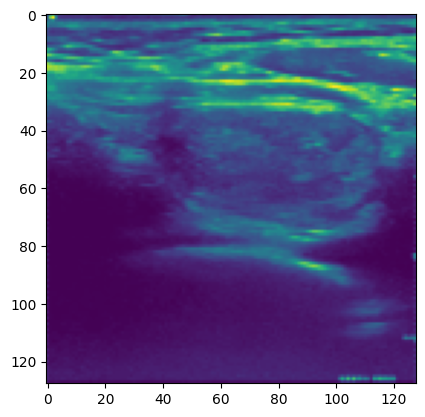

In [8]:
plt.imshow(image[18][0])

In [9]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [11]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [12]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [13]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale(0.7)_AdamW"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [16]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


train loss : 1.5677613019943237, train IOU : 0.3757437765598297, train DICE : 0.5484298169612885


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 1.6152455806732178, val IOU : 0.04500693082809448, val DICE : 0.08172392845153809
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.8019642233848572, train IOU : 0.392604261636734, train DICE : 0.48775479197502136


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.865450918674469, val IOU : 0.4630417823791504, val DICE : 0.5650790929794312
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.6047922968864441, train IOU : 0.5129996836185455, train DICE : 0.5920653343200684


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.47440117597579956, val IOU : 0.6874437928199768, val DICE : 0.7889052033424377
epoch : 3


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.605377733707428, train IOU : 0.5272071361541748, train DICE : 0.6736065745353699


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.40865468978881836, val IOU : 0.705988347530365, val DICE : 0.8101782202720642
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.5193604379892349, train IOU : 0.5711029469966888, train DICE : 0.7027211487293243


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4369772672653198, val IOU : 0.6542376279830933, val DICE : 0.7755197286605835
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.5511398017406464, train IOU : 0.52839295566082, train DICE : 0.666182667016983


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4599267542362213, val IOU : 0.6295979619026184, val DICE : 0.7534984350204468
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.5199820101261139, train IOU : 0.5401735603809357, train DICE : 0.6900583505630493


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4195246398448944, val IOU : 0.6619613766670227, val DICE : 0.77724289894104
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.5113675892353058, train IOU : 0.5651436150074005, train DICE : 0.689052939414978


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3812832832336426, val IOU : 0.7046579718589783, val DICE : 0.8058826327323914
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.48991619050502777, train IOU : 0.5845764577388763, train DICE : 0.7191326320171356


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3799394965171814, val IOU : 0.7022541761398315, val DICE : 0.8010690808296204
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.5069222450256348, train IOU : 0.5788670182228088, train DICE : 0.7183892130851746


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.3964783251285553, val IOU : 0.682155966758728, val DICE : 0.779059648513794
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.489924818277359, train IOU : 0.5885291695594788, train DICE : 0.7037077248096466


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.3894064724445343, val IOU : 0.6915298104286194, val DICE : 0.7814634442329407
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.5118094384670258, train IOU : 0.5608474612236023, train DICE : 0.6830967366695404


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3701927959918976, val IOU : 0.7178522348403931, val DICE : 0.7998591661453247
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.5109673142433167, train IOU : 0.5629086196422577, train DICE : 0.7041721045970917


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.36622339487075806, val IOU : 0.7275394797325134, val DICE : 0.8068429827690125
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.4754985421895981, train IOU : 0.5941468775272369, train DICE : 0.7283084988594055


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3670945167541504, val IOU : 0.7264004349708557, val DICE : 0.8026229739189148
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.4760645627975464, train IOU : 0.5794881582260132, train DICE : 0.7189838886260986


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.36862340569496155, val IOU : 0.7258231043815613, val DICE : 0.7994599342346191
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.4805980771780014, train IOU : 0.5872799456119537, train DICE : 0.7087560296058655


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.37037190794944763, val IOU : 0.7328547835350037, val DICE : 0.8074361085891724
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.5457392930984497, train IOU : 0.5683347284793854, train DICE : 0.6872932314872742


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.37470799684524536, val IOU : 0.7275147438049316, val DICE : 0.8017373085021973
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.48098254203796387, train IOU : 0.5705739557743073, train DICE : 0.7168819308280945


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.38282373547554016, val IOU : 0.7078635096549988, val DICE : 0.7836841344833374
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.494528591632843, train IOU : 0.5589883029460907, train DICE : 0.6829563975334167


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.37678977847099304, val IOU : 0.7205598950386047, val DICE : 0.7948312759399414
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.5015745908021927, train IOU : 0.5751301646232605, train DICE : 0.6916410624980927


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.38049936294555664, val IOU : 0.7288157343864441, val DICE : 0.8020491003990173
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.432808518409729, train IOU : 0.6148987710475922, train DICE : 0.7346777617931366


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3709551692008972, val IOU : 0.7287318706512451, val DICE : 0.8001893758773804
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.4332023710012436, train IOU : 0.6213045120239258, train DICE : 0.7333376407623291


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.36329808831214905, val IOU : 0.733057975769043, val DICE : 0.8031919598579407
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.41170938313007355, train IOU : 0.6503975987434387, train DICE : 0.7479325830936432


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.35874131321907043, val IOU : 0.738385796546936, val DICE : 0.8097123503684998
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.43110376596450806, train IOU : 0.6325689256191254, train DICE : 0.7497193217277527


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.35644349455833435, val IOU : 0.7398603558540344, val DICE : 0.8117787837982178
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.4772945046424866, train IOU : 0.5955315828323364, train DICE : 0.6933509409427643


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3614733815193176, val IOU : 0.7367287874221802, val DICE : 0.805493175983429
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.43699876964092255, train IOU : 0.6182668209075928, train DICE : 0.7386845946311951


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3791660666465759, val IOU : 0.7327939867973328, val DICE : 0.8068892359733582
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.4301958382129669, train IOU : 0.6546783447265625, train DICE : 0.7525545060634613


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.38995859026908875, val IOU : 0.7282655835151672, val DICE : 0.8015936017036438
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.4316748380661011, train IOU : 0.6091883778572083, train DICE : 0.7295449376106262


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.379357248544693, val IOU : 0.7321842312812805, val DICE : 0.805741012096405
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.4303867816925049, train IOU : 0.6290492117404938, train DICE : 0.7347423434257507


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3804124891757965, val IOU : 0.7324394583702087, val DICE : 0.8096987009048462
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.41490788757801056, train IOU : 0.6482348740100861, train DICE : 0.7568991780281067


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3778112828731537, val IOU : 0.733507513999939, val DICE : 0.8100788593292236
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.4573814272880554, train IOU : 0.6265752613544464, train DICE : 0.7322984337806702


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.362342894077301, val IOU : 0.738139808177948, val DICE : 0.8084990382194519
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.41269172728061676, train IOU : 0.6244713068008423, train DICE : 0.7479957342147827


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3638499081134796, val IOU : 0.7384780645370483, val DICE : 0.8106524348258972
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.43614523112773895, train IOU : 0.6262128353118896, train DICE : 0.7454527318477631


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.39919334650039673, val IOU : 0.7205387353897095, val DICE : 0.806986391544342
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.42314833402633667, train IOU : 0.6474986970424652, train DICE : 0.7657254636287689


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4078434705734253, val IOU : 0.7139178514480591, val DICE : 0.8009548187255859
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.3933914303779602, train IOU : 0.6583950221538544, train DICE : 0.7651433944702148


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3843561112880707, val IOU : 0.7275529503822327, val DICE : 0.8038730621337891
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.43462681770324707, train IOU : 0.6197752058506012, train DICE : 0.737944483757019


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.36785539984703064, val IOU : 0.7344602942466736, val DICE : 0.8088972568511963
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.41573522984981537, train IOU : 0.6243859231472015, train DICE : 0.7529144883155823


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3654363453388214, val IOU : 0.7368320822715759, val DICE : 0.8149985671043396
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3989013433456421, train IOU : 0.6536563634872437, train DICE : 0.7605839669704437


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.37539082765579224, val IOU : 0.7318658828735352, val DICE : 0.8153368830680847
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.40251441299915314, train IOU : 0.6583697199821472, train DICE : 0.7667277753353119


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3576187193393707, val IOU : 0.739928662776947, val DICE : 0.8213116526603699
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3635294586420059, train IOU : 0.6521441042423248, train DICE : 0.7828332185745239


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.35474005341529846, val IOU : 0.7423813939094543, val DICE : 0.8220090270042419
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.3739006966352463, train IOU : 0.6577874720096588, train DICE : 0.7731649279594421


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.39650729298591614, val IOU : 0.7222643494606018, val DICE : 0.8100659251213074
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3886474370956421, train IOU : 0.6626072824001312, train DICE : 0.7666729390621185


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.4376469552516937, val IOU : 0.695121705532074, val DICE : 0.7897257208824158
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3900321424007416, train IOU : 0.6597943305969238, train DICE : 0.7672915756702423


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4276648759841919, val IOU : 0.7002978920936584, val DICE : 0.7899389266967773
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.36957280337810516, train IOU : 0.6706568002700806, train DICE : 0.7872398495674133


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.38390228152275085, val IOU : 0.72580486536026, val DICE : 0.8080081939697266
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.39028458297252655, train IOU : 0.6382765471935272, train DICE : 0.7549067735671997


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.36705636978149414, val IOU : 0.7357596158981323, val DICE : 0.8212947249412537
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.4261733442544937, train IOU : 0.6406722068786621, train DICE : 0.7691299915313721


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.36823004484176636, val IOU : 0.7340785264968872, val DICE : 0.8198539614677429
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3630817234516144, train IOU : 0.6701871156692505, train DICE : 0.7852579057216644


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.38054361939430237, val IOU : 0.7252313494682312, val DICE : 0.8077744245529175
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.3736034482717514, train IOU : 0.6583820581436157, train DICE : 0.7674977779388428


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.40868526697158813, val IOU : 0.7116677761077881, val DICE : 0.7976357340812683
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3586588501930237, train IOU : 0.7007533013820648, train DICE : 0.7915785908699036


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4132983088493347, val IOU : 0.7103495001792908, val DICE : 0.8022570013999939
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.38029223680496216, train IOU : 0.7034700810909271, train DICE : 0.7912004590034485


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.38363805413246155, val IOU : 0.7292630076408386, val DICE : 0.8116066455841064
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.35690318048000336, train IOU : 0.6932083964347839, train DICE : 0.792243242263794


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.36132505536079407, val IOU : 0.7395294904708862, val DICE : 0.8177460432052612
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.39964430034160614, train IOU : 0.6256353855133057, train DICE : 0.7462991774082184


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3509998023509979, val IOU : 0.7429936528205872, val DICE : 0.8272684216499329
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3538058400154114, train IOU : 0.691622257232666, train DICE : 0.8014162480831146


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.36212459206581116, val IOU : 0.7386575937271118, val DICE : 0.8290666341781616
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.4121038615703583, train IOU : 0.674398809671402, train DICE : 0.7622919380664825


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3507634997367859, val IOU : 0.740576982498169, val DICE : 0.8262850046157837
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3835880011320114, train IOU : 0.667079746723175, train DICE : 0.7677842974662781


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.35159745812416077, val IOU : 0.733201265335083, val DICE : 0.8128974437713623
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3548554927110672, train IOU : 0.6749314665794373, train DICE : 0.7743876874446869


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3574317395687103, val IOU : 0.732582688331604, val DICE : 0.8104059100151062
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3576513081789017, train IOU : 0.6814782619476318, train DICE : 0.7928014695644379


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.37353894114494324, val IOU : 0.7311955690383911, val DICE : 0.8132899403572083
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3724362254142761, train IOU : 0.6860334277153015, train DICE : 0.7840755581855774


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3843126595020294, val IOU : 0.7282645106315613, val DICE : 0.8149828314781189
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3423693925142288, train IOU : 0.7034420073032379, train DICE : 0.7933885753154755


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.36949148774147034, val IOU : 0.7362635135650635, val DICE : 0.8215662837028503
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3095948100090027, train IOU : 0.717197060585022, train DICE : 0.8103394508361816


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3561210334300995, val IOU : 0.7427271604537964, val DICE : 0.8273417353630066
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.35695433616638184, train IOU : 0.6969169080257416, train DICE : 0.8001636862754822


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34941795468330383, val IOU : 0.7460917234420776, val DICE : 0.8299576044082642
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3445608466863632, train IOU : 0.699150562286377, train DICE : 0.7997537553310394


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.35556426644325256, val IOU : 0.7412524819374084, val DICE : 0.8234454989433289
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.3361174315214157, train IOU : 0.6885292828083038, train DICE : 0.7998940050601959


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.4007009267807007, val IOU : 0.7144016623497009, val DICE : 0.7978342175483704
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3659389466047287, train IOU : 0.6794390082359314, train DICE : 0.7908734083175659


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.42961105704307556, val IOU : 0.6983317732810974, val DICE : 0.7881323099136353
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.3377802222967148, train IOU : 0.6997176706790924, train DICE : 0.810371994972229


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.4026874005794525, val IOU : 0.7175350189208984, val DICE : 0.8061529397964478
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3534536361694336, train IOU : 0.6807830631732941, train DICE : 0.7918163537979126


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.37191733717918396, val IOU : 0.7366656064987183, val DICE : 0.8223108053207397
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.361936017870903, train IOU : 0.6863752901554108, train DICE : 0.7977675795555115


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3583679497241974, val IOU : 0.7436984181404114, val DICE : 0.8289349675178528
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.3768436461687088, train IOU : 0.6775976717472076, train DICE : 0.7860672175884247


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.35438287258148193, val IOU : 0.7409836053848267, val DICE : 0.8265861868858337
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.3640318363904953, train IOU : 0.6992708444595337, train DICE : 0.7978807389736176


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.35388991236686707, val IOU : 0.7377826571464539, val DICE : 0.8221054077148438
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.3473634421825409, train IOU : 0.7035067975521088, train DICE : 0.8054705560207367


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3472155034542084, val IOU : 0.7423161864280701, val DICE : 0.8235397338867188
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.3253070116043091, train IOU : 0.7008865475654602, train DICE : 0.8048956990242004


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34394925832748413, val IOU : 0.7495845556259155, val DICE : 0.829752504825592
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.35450364649295807, train IOU : 0.6917155385017395, train DICE : 0.7888849973678589


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3543761670589447, val IOU : 0.7478047609329224, val DICE : 0.8278923630714417
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.336479589343071, train IOU : 0.7167418003082275, train DICE : 0.8065713346004486


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3629397749900818, val IOU : 0.7411713600158691, val DICE : 0.8204503059387207
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.3332624286413193, train IOU : 0.7033401429653168, train DICE : 0.7935359477996826


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.35631757974624634, val IOU : 0.742159903049469, val DICE : 0.8234049081802368
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2987557053565979, train IOU : 0.7124955654144287, train DICE : 0.813381552696228


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34520190954208374, val IOU : 0.7556316256523132, val DICE : 0.8368908166885376
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.36716416478157043, train IOU : 0.7063511908054352, train DICE : 0.8000022172927856


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33737966418266296, val IOU : 0.7593904733657837, val DICE : 0.8405801653862
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.34297777712345123, train IOU : 0.7020832002162933, train DICE : 0.8056288957595825


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.34057164192199707, val IOU : 0.751184344291687, val DICE : 0.8317254781723022
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3295641988515854, train IOU : 0.6913284361362457, train DICE : 0.8049300014972687


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.35460057854652405, val IOU : 0.7415023446083069, val DICE : 0.823822557926178
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.34901678562164307, train IOU : 0.7094461023807526, train DICE : 0.7996096909046173


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3672923445701599, val IOU : 0.7350859045982361, val DICE : 0.8191782832145691
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3060261905193329, train IOU : 0.7407172322273254, train DICE : 0.8250437080860138


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3730788230895996, val IOU : 0.7273047566413879, val DICE : 0.8165017366409302
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.3312881886959076, train IOU : 0.7140550911426544, train DICE : 0.8010755479335785


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.3565623164176941, val IOU : 0.7358842492103577, val DICE : 0.8252832889556885
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.32049936056137085, train IOU : 0.7251733541488647, train DICE : 0.8018434643745422


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3462531864643097, val IOU : 0.7424983978271484, val DICE : 0.8308246731758118
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.3215616047382355, train IOU : 0.7006407380104065, train DICE : 0.8191601932048798


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.34735241532325745, val IOU : 0.7470576763153076, val DICE : 0.8333260416984558
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3231920748949051, train IOU : 0.7151013314723969, train DICE : 0.8041432499885559


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.3577776551246643, val IOU : 0.7452043294906616, val DICE : 0.8317071795463562
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.3139062225818634, train IOU : 0.7275770008563995, train DICE : 0.8244330286979675


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3749783933162689, val IOU : 0.7375814318656921, val DICE : 0.8237464427947998
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2944825738668442, train IOU : 0.7396633327007294, train DICE : 0.8299149870872498


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.36788210272789, val IOU : 0.7370226383209229, val DICE : 0.8214044570922852
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.33674611151218414, train IOU : 0.7214938998222351, train DICE : 0.8070323765277863


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.353829026222229, val IOU : 0.7389468550682068, val DICE : 0.8208726644515991
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.31156787276268005, train IOU : 0.7069845497608185, train DICE : 0.8129190504550934


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3641253113746643, val IOU : 0.7318503260612488, val DICE : 0.8173049688339233
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.29506389796733856, train IOU : 0.7426749765872955, train DICE : 0.8175479769706726


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.39886796474456787, val IOU : 0.7152551412582397, val DICE : 0.8067005276679993
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.3431209921836853, train IOU : 0.7069489359855652, train DICE : 0.8124529421329498


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3797845244407654, val IOU : 0.7276932001113892, val DICE : 0.8161098957061768
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.297457680106163, train IOU : 0.7350239753723145, train DICE : 0.8295001089572906


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.3388848602771759, val IOU : 0.7459613680839539, val DICE : 0.8301899433135986
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.31906044483184814, train IOU : 0.7128249406814575, train DICE : 0.8110074400901794


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32817181944847107, val IOU : 0.7513577938079834, val DICE : 0.8343768119812012
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3028075248003006, train IOU : 0.7292244136333466, train DICE : 0.8249251842498779


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3302887976169586, val IOU : 0.7583972811698914, val DICE : 0.8382747173309326
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3164922446012497, train IOU : 0.7400949001312256, train DICE : 0.8304807543754578


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3372301757335663, val IOU : 0.7561545968055725, val DICE : 0.8366488218307495
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3040059208869934, train IOU : 0.726654589176178, train DICE : 0.8154555559158325


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34299007058143616, val IOU : 0.7476242780685425, val DICE : 0.8300134539604187
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.31756988167762756, train IOU : 0.716993123292923, train DICE : 0.8211943507194519


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3458186686038971, val IOU : 0.7421338558197021, val DICE : 0.8270307183265686
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.29035069048404694, train IOU : 0.7473853826522827, train DICE : 0.8278127908706665


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3414086699485779, val IOU : 0.7469442486763, val DICE : 0.8317515254020691
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.32105790078639984, train IOU : 0.7274431884288788, train DICE : 0.8186732232570648


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32853826880455017, val IOU : 0.7586576342582703, val DICE : 0.8396134376525879
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.29436342418193817, train IOU : 0.7382729053497314, train DICE : 0.8345595002174377


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3216487765312195, val IOU : 0.7632330060005188, val DICE : 0.8421443104743958
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2928719222545624, train IOU : 0.7514094710350037, train DICE : 0.8317962288856506


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3293176591396332, val IOU : 0.7614602446556091, val DICE : 0.8415418863296509
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.30935075879096985, train IOU : 0.7029926776885986, train DICE : 0.8199232816696167


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.3401339650154114, val IOU : 0.7561030983924866, val DICE : 0.8382914066314697
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2851451486349106, train IOU : 0.7442517876625061, train DICE : 0.8390966653823853


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.335401326417923, val IOU : 0.7578708529472351, val DICE : 0.8382085561752319
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.27993977069854736, train IOU : 0.7629886269569397, train DICE : 0.8419622182846069


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32591110467910767, val IOU : 0.7547793984413147, val DICE : 0.8366778492927551
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.32526634633541107, train IOU : 0.7197274565696716, train DICE : 0.8138362169265747


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32837381958961487, val IOU : 0.7504338026046753, val DICE : 0.8329351544380188
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.3149123340845108, train IOU : 0.7018735408782959, train DICE : 0.8156848549842834


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.33977288007736206, val IOU : 0.7554312348365784, val DICE : 0.8348605632781982
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.2983948439359665, train IOU : 0.7372525632381439, train DICE : 0.8262640237808228


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.38558802008628845, val IOU : 0.7341404557228088, val DICE : 0.8192137479782104
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.30465589463710785, train IOU : 0.7447309792041779, train DICE : 0.8156282007694244


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.379002183675766, val IOU : 0.7335067391395569, val DICE : 0.8187487721443176
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2781780809164047, train IOU : 0.7560938000679016, train DICE : 0.8369880020618439


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34629708528518677, val IOU : 0.7491504549980164, val DICE : 0.8295167684555054
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.28821994364261627, train IOU : 0.7234726250171661, train DICE : 0.8140722513198853


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33508485555648804, val IOU : 0.7553635239601135, val DICE : 0.8361889123916626
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.30331993103027344, train IOU : 0.7356604635715485, train DICE : 0.8207312822341919


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.359913170337677, val IOU : 0.7420583963394165, val DICE : 0.825245201587677
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.28289182484149933, train IOU : 0.7409681081771851, train DICE : 0.8289898633956909


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.41152223944664, val IOU : 0.7058678865432739, val DICE : 0.795242428779602
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.288649320602417, train IOU : 0.7357400059700012, train DICE : 0.8135355114936829


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.40941017866134644, val IOU : 0.7070750594139099, val DICE : 0.7959738373756409
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.3224198818206787, train IOU : 0.7170425653457642, train DICE : 0.802494615316391


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.35951951146125793, val IOU : 0.7395786046981812, val DICE : 0.8240520358085632
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2968447506427765, train IOU : 0.7528556287288666, train DICE : 0.830195426940918


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33898961544036865, val IOU : 0.7512823343276978, val DICE : 0.8336511254310608
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.29447774589061737, train IOU : 0.752968430519104, train DICE : 0.8358082175254822


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3464406728744507, val IOU : 0.7484442591667175, val DICE : 0.8295590281486511
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.30708904564380646, train IOU : 0.7130401134490967, train DICE : 0.8085521757602692


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3593218922615051, val IOU : 0.7448855638504028, val DICE : 0.825538694858551
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.3060886412858963, train IOU : 0.745744377374649, train DICE : 0.8182568848133087


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3961392343044281, val IOU : 0.7237338423728943, val DICE : 0.8096141815185547
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.29506731033325195, train IOU : 0.767341136932373, train DICE : 0.8245465457439423


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3717882037162781, val IOU : 0.7346649169921875, val DICE : 0.8198596239089966
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.3057478368282318, train IOU : 0.7338221371173859, train DICE : 0.8250772953033447


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3486166000366211, val IOU : 0.7437961101531982, val DICE : 0.8279719352722168
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.30214598774909973, train IOU : 0.7219529151916504, train DICE : 0.8259220719337463


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.335467129945755, val IOU : 0.7515672445297241, val DICE : 0.8350690603256226
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.29587146639823914, train IOU : 0.733356237411499, train DICE : 0.8157451152801514


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3310016393661499, val IOU : 0.7630219459533691, val DICE : 0.8418996334075928
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2840493619441986, train IOU : 0.7462184429168701, train DICE : 0.832250565290451


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.33488115668296814, val IOU : 0.7632680535316467, val DICE : 0.8425531387329102
epoch : 122


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3115512281656265, train IOU : 0.7465526759624481, train DICE : 0.8266182243824005


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33175572752952576, val IOU : 0.7565704584121704, val DICE : 0.8369986414909363
epoch : 123


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.28533533215522766, train IOU : 0.7489580512046814, train DICE : 0.8352310061454773


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33469486236572266, val IOU : 0.7452898025512695, val DICE : 0.8280027508735657
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.3023484796285629, train IOU : 0.7104810774326324, train DICE : 0.8178672790527344


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.32934221625328064, val IOU : 0.7504569292068481, val DICE : 0.8317676186561584
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3044489920139313, train IOU : 0.7558490633964539, train DICE : 0.8198733627796173


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3368365466594696, val IOU : 0.7519477009773254, val DICE : 0.8312195539474487
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2797648161649704, train IOU : 0.7690828442573547, train DICE : 0.833917886018753


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34644436836242676, val IOU : 0.7473928332328796, val DICE : 0.8271036148071289
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.28290489315986633, train IOU : 0.7255347371101379, train DICE : 0.8161020278930664


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3476397693157196, val IOU : 0.7511240243911743, val DICE : 0.8287510275840759
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2743399292230606, train IOU : 0.7482700645923615, train DICE : 0.8393092751502991


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3558933138847351, val IOU : 0.7474563121795654, val DICE : 0.8278260827064514
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2967153340578079, train IOU : 0.7518579363822937, train DICE : 0.8353874683380127


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3568509817123413, val IOU : 0.7426452040672302, val DICE : 0.8237942457199097
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.28309008479118347, train IOU : 0.7439061105251312, train DICE : 0.8537805676460266


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.349931538105011, val IOU : 0.7404457330703735, val DICE : 0.8226725459098816
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2734099179506302, train IOU : 0.7416835725307465, train DICE : 0.8221876323223114


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34452441334724426, val IOU : 0.7421736717224121, val DICE : 0.823932945728302
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.305511012673378, train IOU : 0.7380701899528503, train DICE : 0.822409451007843


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3546018600463867, val IOU : 0.7435210347175598, val DICE : 0.8238855600357056
epoch : 133


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.27980098128318787, train IOU : 0.754026859998703, train DICE : 0.8324342370033264


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.36231404542922974, val IOU : 0.7435103058815002, val DICE : 0.8235348463058472
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.27017854154109955, train IOU : 0.7770234048366547, train DICE : 0.8412319421768188


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3452684283256531, val IOU : 0.7551918029785156, val DICE : 0.83328777551651
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.28829480707645416, train IOU : 0.7435343265533447, train DICE : 0.8430454730987549


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34616443514823914, val IOU : 0.7538358569145203, val DICE : 0.8334457278251648
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2695293426513672, train IOU : 0.7595937550067902, train DICE : 0.8378708064556122


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36153262853622437, val IOU : 0.7469825148582458, val DICE : 0.8290769457817078
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.27271533012390137, train IOU : 0.7582469880580902, train DICE : 0.8405648767948151


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3706267774105072, val IOU : 0.7457579970359802, val DICE : 0.8287661075592041
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2782648950815201, train IOU : 0.7398592829704285, train DICE : 0.8256040215492249


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3515906035900116, val IOU : 0.7548197507858276, val DICE : 0.8367474675178528
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2761621028184891, train IOU : 0.7601355016231537, train DICE : 0.8403266072273254


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3262374699115753, val IOU : 0.7613978981971741, val DICE : 0.8426094055175781
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.25171247124671936, train IOU : 0.7793935835361481, train DICE : 0.8524417579174042


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3226582705974579, val IOU : 0.7570379376411438, val DICE : 0.8383670449256897
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2706505358219147, train IOU : 0.7579781711101532, train DICE : 0.8410792052745819


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3224245607852936, val IOU : 0.7544841170310974, val DICE : 0.8372179865837097
epoch : 142


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24646488577127457, train IOU : 0.7855267226696014, train DICE : 0.855188250541687


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.32447731494903564, val IOU : 0.7529716491699219, val DICE : 0.8376289010047913
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2736939340829849, train IOU : 0.7728931307792664, train DICE : 0.8506748378276825


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3316024839878082, val IOU : 0.7482187747955322, val DICE : 0.832151472568512
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.250594899058342, train IOU : 0.7729847133159637, train DICE : 0.8601382374763489


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.3344177305698395, val IOU : 0.7562655806541443, val DICE : 0.8351190686225891
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.24326803535223007, train IOU : 0.7801360785961151, train DICE : 0.8628012537956238


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33882638812065125, val IOU : 0.7569770216941833, val DICE : 0.8378623127937317
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.2551114186644554, train IOU : 0.7747235298156738, train DICE : 0.8538038730621338


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3401881158351898, val IOU : 0.7559773325920105, val DICE : 0.8369669914245605
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2642108201980591, train IOU : 0.7583270967006683, train DICE : 0.8501027524471283


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.353157103061676, val IOU : 0.750917911529541, val DICE : 0.8323671221733093
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.3064879775047302, train IOU : 0.7258445024490356, train DICE : 0.8376639187335968


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.36274224519729614, val IOU : 0.7489001750946045, val DICE : 0.8306332230567932
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.26882295310497284, train IOU : 0.7760144472122192, train DICE : 0.8410367667675018


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.35489702224731445, val IOU : 0.7541342377662659, val DICE : 0.8349790573120117
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.27193450182676315, train IOU : 0.768827348947525, train DICE : 0.8476250469684601


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3420068919658661, val IOU : 0.7591782212257385, val DICE : 0.8403397798538208
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.24661844968795776, train IOU : 0.7841528952121735, train DICE : 0.8568080365657806


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3306407332420349, val IOU : 0.763542115688324, val DICE : 0.8440402150154114
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2588425874710083, train IOU : 0.7569707036018372, train DICE : 0.8449378311634064


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3370892405509949, val IOU : 0.7615490555763245, val DICE : 0.8417434096336365
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.25440046191215515, train IOU : 0.7601133286952972, train DICE : 0.8570409417152405


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.35758012533187866, val IOU : 0.7549086213111877, val DICE : 0.8353164196014404
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2491767406463623, train IOU : 0.7937377393245697, train DICE : 0.8572157621383667


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3371470272541046, val IOU : 0.7637317776679993, val DICE : 0.8428106307983398
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.248415507376194, train IOU : 0.7737360298633575, train DICE : 0.8603465855121613


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32443445920944214, val IOU : 0.7689228653907776, val DICE : 0.8493324518203735
epoch : 156


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24958164989948273, train IOU : 0.7794317305088043, train DICE : 0.8648614585399628


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3166191875934601, val IOU : 0.769760251045227, val DICE : 0.8542295694351196
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2444222867488861, train IOU : 0.7891665995121002, train DICE : 0.8721186816692352


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3180256485939026, val IOU : 0.7650902271270752, val DICE : 0.8482044339179993
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.3008617013692856, train IOU : 0.7438590228557587, train DICE : 0.8360715508460999


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3538801372051239, val IOU : 0.7451664209365845, val DICE : 0.8256175518035889
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2868681699037552, train IOU : 0.7251088917255402, train DICE : 0.8292820155620575


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.4046010971069336, val IOU : 0.7202644348144531, val DICE : 0.806827962398529
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2650843411684036, train IOU : 0.7454820871353149, train DICE : 0.8364434242248535


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.4100402295589447, val IOU : 0.7212749123573303, val DICE : 0.8104732632637024
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.27742910385131836, train IOU : 0.7748884558677673, train DICE : 0.8507430553436279


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.33133915066719055, val IOU : 0.7574019432067871, val DICE : 0.842540979385376
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.25436021387577057, train IOU : 0.7538295090198517, train DICE : 0.8568018674850464


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3201610743999481, val IOU : 0.7553948760032654, val DICE : 0.8411658406257629
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.26012684404850006, train IOU : 0.7439208328723907, train DICE : 0.8476651906967163


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.31676673889160156, val IOU : 0.7626892328262329, val DICE : 0.8464161157608032
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.26904337108135223, train IOU : 0.757905125617981, train DICE : 0.8543306291103363


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34843873977661133, val IOU : 0.7577758431434631, val DICE : 0.8398277163505554
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.26440154016017914, train IOU : 0.7606843709945679, train DICE : 0.8546859323978424


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.39412400126457214, val IOU : 0.732743501663208, val DICE : 0.8203930258750916
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.289517343044281, train IOU : 0.7418892085552216, train DICE : 0.8452007472515106


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3808872103691101, val IOU : 0.734414279460907, val DICE : 0.820416271686554
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.26458171010017395, train IOU : 0.7603684961795807, train DICE : 0.8553759753704071


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33981651067733765, val IOU : 0.7525677680969238, val DICE : 0.8332934975624084
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.26738691329956055, train IOU : 0.7574625611305237, train DICE : 0.848517119884491


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3203360140323639, val IOU : 0.7609801292419434, val DICE : 0.8427859544754028
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2748817950487137, train IOU : 0.774196445941925, train DICE : 0.8612521290779114


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.31727492809295654, val IOU : 0.7626038193702698, val DICE : 0.8453218340873718
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.24693891406059265, train IOU : 0.7721297144889832, train DICE : 0.8630070090293884


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32603955268859863, val IOU : 0.760972261428833, val DICE : 0.8435379862785339
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.25661636888980865, train IOU : 0.7700503170490265, train DICE : 0.855853259563446


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.354341596364975, val IOU : 0.7560778260231018, val DICE : 0.8373113870620728
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.24718499183654785, train IOU : 0.7794789671897888, train DICE : 0.863921046257019


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.359213262796402, val IOU : 0.755648136138916, val DICE : 0.837702214717865
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.25165731459856033, train IOU : 0.7803567349910736, train DICE : 0.8550494909286499


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33470916748046875, val IOU : 0.7637950778007507, val DICE : 0.8447034358978271
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.23972797393798828, train IOU : 0.7717722058296204, train DICE : 0.8568756580352783


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3206872344017029, val IOU : 0.7651951909065247, val DICE : 0.8459045886993408
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22612646967172623, train IOU : 0.8010491132736206, train DICE : 0.8753397166728973


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32189691066741943, val IOU : 0.7576432228088379, val DICE : 0.8392215967178345
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2629726976156235, train IOU : 0.7642456293106079, train DICE : 0.844133198261261


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.33453795313835144, val IOU : 0.7495792508125305, val DICE : 0.8316879272460938
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.22828806191682816, train IOU : 0.7837825417518616, train DICE : 0.8637576699256897


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3503641188144684, val IOU : 0.7467788457870483, val DICE : 0.8279963731765747
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2652224525809288, train IOU : 0.7543889284133911, train DICE : 0.8470553457736969


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.357455849647522, val IOU : 0.7519025802612305, val DICE : 0.8316300511360168
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26208554208278656, train IOU : 0.7719021439552307, train DICE : 0.8354352712631226


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3308255672454834, val IOU : 0.7659452557563782, val DICE : 0.8440247774124146
epoch : 180


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26284730434417725, train IOU : 0.7685607671737671, train DICE : 0.8595505654811859


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.32828187942504883, val IOU : 0.7627120614051819, val DICE : 0.8420749306678772
epoch : 181


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2691912353038788, train IOU : 0.7368700206279755, train DICE : 0.8406990170478821


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33685243129730225, val IOU : 0.761289656162262, val DICE : 0.8395450711250305
epoch : 182


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.25406698882579803, train IOU : 0.7658649682998657, train DICE : 0.8542916476726532


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.35531917214393616, val IOU : 0.7512766718864441, val DICE : 0.8325478434562683
epoch : 183


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.2571559324860573, train IOU : 0.7892014384269714, train DICE : 0.8521324694156647


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3544827401638031, val IOU : 0.7449942231178284, val DICE : 0.8280481696128845
epoch : 184


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.24844062328338623, train IOU : 0.7840975522994995, train DICE : 0.8482511639595032


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3417800962924957, val IOU : 0.7460294365882874, val DICE : 0.8298688530921936
epoch : 185


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.25850116461515427, train IOU : 0.7591732442378998, train DICE : 0.8511719703674316


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33490243554115295, val IOU : 0.7536365389823914, val DICE : 0.8363761901855469
epoch : 186


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.24032118916511536, train IOU : 0.7858548760414124, train DICE : 0.8542462885379791


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34065133333206177, val IOU : 0.7571631073951721, val DICE : 0.8415142893791199
epoch : 187


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.2437509447336197, train IOU : 0.7968075573444366, train DICE : 0.8643003106117249


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34170064330101013, val IOU : 0.7590446472167969, val DICE : 0.8439464569091797
epoch : 188


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.226400688290596, train IOU : 0.8154504597187042, train DICE : 0.8804064989089966


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3347121775150299, val IOU : 0.760000467300415, val DICE : 0.8435496687889099
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.23449460417032242, train IOU : 0.7777926623821259, train DICE : 0.8716447353363037


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3417671024799347, val IOU : 0.7559303045272827, val DICE : 0.8386030793190002
epoch : 190


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.23955519497394562, train IOU : 0.7802402377128601, train DICE : 0.867773562669754


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3437201976776123, val IOU : 0.7587884664535522, val DICE : 0.8382649421691895
epoch : 191


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2258877158164978, train IOU : 0.7723689377307892, train DICE : 0.8714360296726227


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3603112995624542, val IOU : 0.7551907896995544, val DICE : 0.8343335390090942
epoch : 192


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2346600741147995, train IOU : 0.7984755039215088, train DICE : 0.8745410442352295


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.37436428666114807, val IOU : 0.7477276921272278, val DICE : 0.8287957906723022
epoch : 193


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.24495216459035873, train IOU : 0.7737394273281097, train DICE : 0.8638695478439331


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36217939853668213, val IOU : 0.7509301900863647, val DICE : 0.8326196670532227
epoch : 194


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.23948393017053604, train IOU : 0.7759789526462555, train DICE : 0.86777263879776


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3547850549221039, val IOU : 0.7519370913505554, val DICE : 0.8360950946807861
epoch : 195


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.26557260006666183, train IOU : 0.7670213878154755, train DICE : 0.8595775365829468


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.35315999388694763, val IOU : 0.7507922649383545, val DICE : 0.8349705338478088
epoch : 196


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.21277254074811935, train IOU : 0.7982732653617859, train DICE : 0.8792266249656677


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.3577830493450165, val IOU : 0.7462729215621948, val DICE : 0.828971803188324
epoch : 197


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2335348054766655, train IOU : 0.7925392091274261, train DICE : 0.8692785799503326


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.35618340969085693, val IOU : 0.7469590902328491, val DICE : 0.829168975353241
epoch : 198


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21901121735572815, train IOU : 0.7964179515838623, train DICE : 0.8750528693199158


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.35744068026542664, val IOU : 0.7493763566017151, val DICE : 0.8320996761322021
epoch : 199


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2414613589644432, train IOU : 0.7886450588703156, train DICE : 0.8574702441692352


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3585733473300934, val IOU : 0.7498453855514526, val DICE : 0.8341647982597351
epoch : 200


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22332604974508286, train IOU : 0.8079254329204559, train DICE : 0.8762411773204803


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33875772356987, val IOU : 0.7602930068969727, val DICE : 0.8414976596832275
epoch : 201


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.23442916572093964, train IOU : 0.8031792044639587, train DICE : 0.8772507607936859


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3187146782875061, val IOU : 0.7657520174980164, val DICE : 0.8475905656814575
epoch : 202


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.24674572050571442, train IOU : 0.7690832912921906, train DICE : 0.8666285574436188


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3129395544528961, val IOU : 0.7665252685546875, val DICE : 0.8496533036231995
epoch : 203


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.21600942313671112, train IOU : 0.7811768054962158, train DICE : 0.8797343671321869


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.31661951541900635, val IOU : 0.7694095373153687, val DICE : 0.8523382544517517
epoch : 204


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.27593857049942017, train IOU : 0.7499695718288422, train DICE : 0.8404340147972107


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3260795474052429, val IOU : 0.7682203650474548, val DICE : 0.8512292504310608
epoch : 205


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2693878710269928, train IOU : 0.7749107182025909, train DICE : 0.857634961605072


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33561742305755615, val IOU : 0.7653785943984985, val DICE : 0.8445098400115967
epoch : 206


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2513313367962837, train IOU : 0.7699755728244781, train DICE : 0.8460801243782043


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3549528121948242, val IOU : 0.7532637715339661, val DICE : 0.8322063684463501
epoch : 207


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2700541168451309, train IOU : 0.7643060386180878, train DICE : 0.849430501461029


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3417021334171295, val IOU : 0.7559108734130859, val DICE : 0.8360162377357483
epoch : 208


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.259174644947052, train IOU : 0.7694743573665619, train DICE : 0.8571051955223083


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.322552353143692, val IOU : 0.7635103464126587, val DICE : 0.8438334465026855
epoch : 209


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.25506148487329483, train IOU : 0.7885698974132538, train DICE : 0.8575496673583984


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3210567831993103, val IOU : 0.7613695859909058, val DICE : 0.8428322672843933
epoch : 210


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.22055348753929138, train IOU : 0.7924532890319824, train DICE : 0.8709713220596313


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.328494668006897, val IOU : 0.7572821974754333, val DICE : 0.8384637832641602
epoch : 211


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.23303866386413574, train IOU : 0.7890806794166565, train DICE : 0.8725705742835999


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34541603922843933, val IOU : 0.752362847328186, val DICE : 0.8351749777793884
epoch : 212


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2254302278161049, train IOU : 0.7989971935749054, train DICE : 0.8714044094085693


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36915701627731323, val IOU : 0.741584062576294, val DICE : 0.8267530798912048
epoch : 213


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.25033947080373764, train IOU : 0.7696428894996643, train DICE : 0.8589400947093964


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3825666010379791, val IOU : 0.7365618348121643, val DICE : 0.8210443258285522
epoch : 214


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.22978179156780243, train IOU : 0.7946865260601044, train DICE : 0.8689063489437103


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3789757490158081, val IOU : 0.7387616634368896, val DICE : 0.8222422003746033
epoch : 215


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2084154114127159, train IOU : 0.8035549521446228, train DICE : 0.8805191516876221


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.36263900995254517, val IOU : 0.7467532157897949, val DICE : 0.8296369314193726
epoch : 216


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2172195389866829, train IOU : 0.8037912845611572, train DICE : 0.8808256983757019


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3443683087825775, val IOU : 0.7560511827468872, val DICE : 0.837649405002594
epoch : 217


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.24039218574762344, train IOU : 0.7946613729000092, train DICE : 0.8586696088314056


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33835381269454956, val IOU : 0.7584577202796936, val DICE : 0.8403609395027161
epoch : 218


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.2579888850450516, train IOU : 0.763192892074585, train DICE : 0.8613813519477844


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3398683965206146, val IOU : 0.7557679414749146, val DICE : 0.8388859629631042
epoch : 219


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.22222569584846497, train IOU : 0.7875377833843231, train DICE : 0.8675164878368378


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3425491452217102, val IOU : 0.7551459074020386, val DICE : 0.8383467793464661
epoch : 220


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2607450485229492, train IOU : 0.7775891125202179, train DICE : 0.8633179068565369


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.33954256772994995, val IOU : 0.7563371658325195, val DICE : 0.8391647338867188
epoch : 221


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.21434012055397034, train IOU : 0.8200267851352692, train DICE : 0.8716560900211334


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33520662784576416, val IOU : 0.7569903135299683, val DICE : 0.8390154242515564
epoch : 222


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.22088154405355453, train IOU : 0.7867923676967621, train DICE : 0.8745856285095215


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3373691439628601, val IOU : 0.7583699822425842, val DICE : 0.8412219285964966
epoch : 223


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21543243527412415, train IOU : 0.8072611391544342, train DICE : 0.8799557089805603


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3417230546474457, val IOU : 0.7605523467063904, val DICE : 0.8425168991088867
epoch : 224


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2187347635626793, train IOU : 0.8037810325622559, train DICE : 0.8759891390800476


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3501776456832886, val IOU : 0.7584388256072998, val DICE : 0.839819610118866
epoch : 225


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.23463722318410873, train IOU : 0.8020825684070587, train DICE : 0.8712788820266724


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.35774675011634827, val IOU : 0.7527943253517151, val DICE : 0.8356656432151794
epoch : 226


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.24306026846170425, train IOU : 0.7803095281124115, train DICE : 0.8617652356624603


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3492511510848999, val IOU : 0.7546500563621521, val DICE : 0.8369921445846558
epoch : 227


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.26256348192691803, train IOU : 0.7585722208023071, train DICE : 0.8552645146846771


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34777766466140747, val IOU : 0.7537694573402405, val DICE : 0.836052656173706
epoch : 228


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2170826718211174, train IOU : 0.7900079488754272, train DICE : 0.8815018832683563


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3446832597255707, val IOU : 0.7564635276794434, val DICE : 0.8380531072616577
epoch : 229


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.233500137925148, train IOU : 0.7907994389533997, train DICE : 0.8719879984855652


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.341686874628067, val IOU : 0.7563159465789795, val DICE : 0.8400627374649048
epoch : 230


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.20695873349905014, train IOU : 0.8346105813980103, train DICE : 0.8967032134532928


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3336738348007202, val IOU : 0.7585660815238953, val DICE : 0.8412843942642212
epoch : 231


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2179340422153473, train IOU : 0.8140499889850616, train DICE : 0.8822038173675537


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.33625808358192444, val IOU : 0.7545201182365417, val DICE : 0.8364338874816895
epoch : 232


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.25086501240730286, train IOU : 0.7617512345314026, train DICE : 0.8534625172615051


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3481981158256531, val IOU : 0.7469708919525146, val DICE : 0.8300378322601318
epoch : 233


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2175941988825798, train IOU : 0.7935280799865723, train DICE : 0.875386655330658


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3619408905506134, val IOU : 0.7453268766403198, val DICE : 0.8262701034545898
epoch : 234


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.24604175239801407, train IOU : 0.8035745918750763, train DICE : 0.8587328195571899


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.351980984210968, val IOU : 0.7529975175857544, val DICE : 0.8341992497444153
epoch : 235


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.23294534534215927, train IOU : 0.7823821306228638, train DICE : 0.866082102060318


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3307006359100342, val IOU : 0.7616565227508545, val DICE : 0.8420678377151489
epoch : 236


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.25445298850536346, train IOU : 0.7591958045959473, train DICE : 0.8700704276561737


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3269014358520508, val IOU : 0.7624008655548096, val DICE : 0.8430861234664917
epoch : 237


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.21087413281202316, train IOU : 0.8224926888942719, train DICE : 0.8838130831718445


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34150823950767517, val IOU : 0.7590662240982056, val DICE : 0.8402771949768066
epoch : 238


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2067544311285019, train IOU : 0.8184882998466492, train DICE : 0.8867129385471344


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3620719015598297, val IOU : 0.749895453453064, val DICE : 0.8330762386322021
epoch : 239


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2414228841662407, train IOU : 0.7930220365524292, train DICE : 0.8650178015232086


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3621816635131836, val IOU : 0.7480596899986267, val DICE : 0.8313619494438171
epoch : 240


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.23327798396348953, train IOU : 0.7863145768642426, train DICE : 0.8718361854553223


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3533251881599426, val IOU : 0.750204861164093, val DICE : 0.8328399658203125
epoch : 241


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.22203536331653595, train IOU : 0.8099130094051361, train DICE : 0.8711732923984528


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3399059772491455, val IOU : 0.7539800405502319, val DICE : 0.8356810808181763
epoch : 242


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.23174983263015747, train IOU : 0.7861722111701965, train DICE : 0.8745266497135162


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3278665840625763, val IOU : 0.757719874382019, val DICE : 0.8403838276863098
epoch : 243


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.22616607695817947, train IOU : 0.791580319404602, train DICE : 0.8672119379043579


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3233511745929718, val IOU : 0.7604742646217346, val DICE : 0.8429135680198669
epoch : 244


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.19147279113531113, train IOU : 0.8335805535316467, train DICE : 0.8927559852600098


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.32262489199638367, val IOU : 0.7637014985084534, val DICE : 0.8447869420051575
epoch : 245


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.2414834424853325, train IOU : 0.7788936793804169, train DICE : 0.8703973293304443


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32754337787628174, val IOU : 0.7651553750038147, val DICE : 0.8445591330528259
epoch : 246


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.24011606723070145, train IOU : 0.7755416035652161, train DICE : 0.8619457483291626


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3256060481071472, val IOU : 0.7673203945159912, val DICE : 0.8459858894348145
epoch : 247


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19428155571222305, train IOU : 0.8301469087600708, train DICE : 0.8974954187870026


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.32183143496513367, val IOU : 0.7682114243507385, val DICE : 0.8475878238677979
epoch : 248


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.22148625552654266, train IOU : 0.8223563134670258, train DICE : 0.8839813768863678


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3222929537296295, val IOU : 0.7658767700195312, val DICE : 0.8458747863769531
epoch : 249


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.23113157600164413, train IOU : 0.7822553813457489, train DICE : 0.8539167046546936


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32724475860595703, val IOU : 0.7641361355781555, val DICE : 0.8448253870010376
epoch : 250


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.24389375746250153, train IOU : 0.7790977358818054, train DICE : 0.8690515458583832


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.35551586747169495, val IOU : 0.7551512122154236, val DICE : 0.8348295092582703
epoch : 251


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.18747834116220474, train IOU : 0.8371542096138, train DICE : 0.8953518569469452


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3979019224643707, val IOU : 0.7315332293510437, val DICE : 0.816144585609436
epoch : 252


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21295680850744247, train IOU : 0.8123005032539368, train DICE : 0.8838571310043335


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.4088110625743866, val IOU : 0.7246742248535156, val DICE : 0.8107651472091675
epoch : 253


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23025672882795334, train IOU : 0.7857276201248169, train DICE : 0.8619077503681183


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3890308141708374, val IOU : 0.7372152209281921, val DICE : 0.8209285736083984
epoch : 254


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.22563229501247406, train IOU : 0.7943371534347534, train DICE : 0.8779060542583466


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3693510591983795, val IOU : 0.7489084601402283, val DICE : 0.8303657174110413
epoch : 255


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.2252027839422226, train IOU : 0.8108845353126526, train DICE : 0.8708233535289764


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3653503954410553, val IOU : 0.750362753868103, val DICE : 0.8314560651779175
epoch : 256


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.19774557650089264, train IOU : 0.8115494847297668, train DICE : 0.8953953981399536


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.36926373839378357, val IOU : 0.7467191815376282, val DICE : 0.829850435256958
epoch : 257


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19020459055900574, train IOU : 0.8259940445423126, train DICE : 0.8891133964061737


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.366153359413147, val IOU : 0.7478078603744507, val DICE : 0.832181453704834
epoch : 258


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.21086257696151733, train IOU : 0.8143616914749146, train DICE : 0.888295978307724


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34749943017959595, val IOU : 0.7548432946205139, val DICE : 0.8386821150779724
epoch : 259


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20233695209026337, train IOU : 0.815103679895401, train DICE : 0.8877902328968048


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33123573660850525, val IOU : 0.7588485479354858, val DICE : 0.8421729207038879
epoch : 260


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.22768047451972961, train IOU : 0.7837252616882324, train DICE : 0.8755987286567688


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.32342883944511414, val IOU : 0.7590326070785522, val DICE : 0.8430437445640564
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.20135579258203506, train IOU : 0.8124729692935944, train DICE : 0.8819616138935089


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3240051865577698, val IOU : 0.7605468034744263, val DICE : 0.8436725735664368
epoch : 262


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.24742450565099716, train IOU : 0.8053336143493652, train DICE : 0.869207501411438


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33059972524642944, val IOU : 0.760202169418335, val DICE : 0.8415789604187012
epoch : 263


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20608391612768173, train IOU : 0.8108149766921997, train DICE : 0.878493458032608


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33617761731147766, val IOU : 0.758771538734436, val DICE : 0.838811993598938
epoch : 264


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20248568803071976, train IOU : 0.8070463836193085, train DICE : 0.8825263381004333


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3535189926624298, val IOU : 0.7533844709396362, val DICE : 0.8321847319602966
epoch : 265


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2470286339521408, train IOU : 0.7960043847560883, train DICE : 0.8557408154010773


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3637784421443939, val IOU : 0.7480735778808594, val DICE : 0.8285079002380371
epoch : 266


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20532167702913284, train IOU : 0.8159839808940887, train DICE : 0.8897651731967926


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3530115485191345, val IOU : 0.7536087036132812, val DICE : 0.8339096307754517
epoch : 267


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2088078409433365, train IOU : 0.8209856152534485, train DICE : 0.8842111229896545


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.34641340374946594, val IOU : 0.7551214098930359, val DICE : 0.8368330001831055
epoch : 268


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.20560798794031143, train IOU : 0.8016627132892609, train DICE : 0.8853459060192108


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3395257294178009, val IOU : 0.7581561803817749, val DICE : 0.840419590473175
epoch : 269


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.20125476270914078, train IOU : 0.8304438292980194, train DICE : 0.8891661465167999


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33682385087013245, val IOU : 0.7593084573745728, val DICE : 0.8420251607894897
epoch : 270


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.23188797384500504, train IOU : 0.7858448624610901, train DICE : 0.873186320066452


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33339187502861023, val IOU : 0.7621625065803528, val DICE : 0.8427413702011108
epoch : 271


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.21915313601493835, train IOU : 0.8102147877216339, train DICE : 0.8830190896987915


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3293781876564026, val IOU : 0.7622584104537964, val DICE : 0.8428921699523926
epoch : 272


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19419928640127182, train IOU : 0.818055659532547, train DICE : 0.8913619518280029


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33459094166755676, val IOU : 0.7586942315101624, val DICE : 0.8401277661323547
epoch : 273


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.20105255395174026, train IOU : 0.8049293160438538, train DICE : 0.8757844567298889


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34966742992401123, val IOU : 0.7538838982582092, val DICE : 0.8360340595245361
epoch : 274


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.19411197304725647, train IOU : 0.8291626870632172, train DICE : 0.8931732773780823


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3649865388870239, val IOU : 0.7464511394500732, val DICE : 0.830814003944397
epoch : 275


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2195475697517395, train IOU : 0.8181620240211487, train DICE : 0.8833986818790436


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.35054460167884827, val IOU : 0.7528515458106995, val DICE : 0.8355640769004822
epoch : 276


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22980613261461258, train IOU : 0.7897007465362549, train DICE : 0.8782801926136017


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.32973209023475647, val IOU : 0.7584568858146667, val DICE : 0.840634822845459
epoch : 277


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19389276951551437, train IOU : 0.8220485150814056, train DICE : 0.8895086050033569


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.32705968618392944, val IOU : 0.7604005336761475, val DICE : 0.8422961235046387
epoch : 278


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18876320123672485, train IOU : 0.8237044215202332, train DICE : 0.8907002508640289


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.3395291268825531, val IOU : 0.7586072087287903, val DICE : 0.841296911239624
epoch : 279


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2338157519698143, train IOU : 0.8031178116798401, train DICE : 0.871502548456192


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36568745970726013, val IOU : 0.7483272552490234, val DICE : 0.831440806388855
epoch : 280


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20052259415388107, train IOU : 0.8150089681148529, train DICE : 0.89051353931427


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.37521275877952576, val IOU : 0.7438212633132935, val DICE : 0.8261553645133972
epoch : 281


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2271595150232315, train IOU : 0.7884737253189087, train DICE : 0.8629117012023926


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36476120352745056, val IOU : 0.7496248483657837, val DICE : 0.82981938123703
epoch : 282


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.20420465618371964, train IOU : 0.8140689730644226, train DICE : 0.8851767182350159


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3526664972305298, val IOU : 0.7539007067680359, val DICE : 0.8337112665176392
epoch : 283


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.21192827820777893, train IOU : 0.8003321290016174, train DICE : 0.8761169910430908


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34631142020225525, val IOU : 0.7563530802726746, val DICE : 0.8360726237297058
epoch : 284


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.22333429008722305, train IOU : 0.8039452731609344, train DICE : 0.885993093252182


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.344770610332489, val IOU : 0.7551813125610352, val DICE : 0.8354683518409729
epoch : 285


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21448000520467758, train IOU : 0.8072876930236816, train DICE : 0.8835220634937286


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3446178138256073, val IOU : 0.7524885535240173, val DICE : 0.8335000276565552
epoch : 286


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.197519950568676, train IOU : 0.8144921958446503, train DICE : 0.8864996433258057


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3448602557182312, val IOU : 0.7532406449317932, val DICE : 0.8347605466842651
epoch : 287


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.21150176227092743, train IOU : 0.8124429285526276, train DICE : 0.8816606402397156


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3493680953979492, val IOU : 0.7538952231407166, val DICE : 0.836404025554657
epoch : 288


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2094087451696396, train IOU : 0.8228606581687927, train DICE : 0.8765873908996582


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3542100489139557, val IOU : 0.7525355815887451, val DICE : 0.836440920829773
epoch : 289


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.21371378004550934, train IOU : 0.8161247074604034, train DICE : 0.8903923630714417


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3421648144721985, val IOU : 0.7554143071174622, val DICE : 0.8399468660354614
epoch : 290


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17797140032052994, train IOU : 0.8342673182487488, train DICE : 0.8974597454071045


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3358442187309265, val IOU : 0.7570539116859436, val DICE : 0.84059077501297
epoch : 291


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2223915383219719, train IOU : 0.812038242816925, train DICE : 0.8721467852592468


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33815088868141174, val IOU : 0.7551577687263489, val DICE : 0.8381450176239014
epoch : 292


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.20340430736541748, train IOU : 0.8174995481967926, train DICE : 0.8840141892433167


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34780165553092957, val IOU : 0.7509273290634155, val DICE : 0.8320202231407166
epoch : 293


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.2000626102089882, train IOU : 0.8209144175052643, train DICE : 0.8914770781993866


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3579261302947998, val IOU : 0.7472962141036987, val DICE : 0.8279133439064026
epoch : 294


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.21448753774166107, train IOU : 0.8142247796058655, train DICE : 0.876943826675415


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3564014434814453, val IOU : 0.7490698099136353, val DICE : 0.8301034569740295
epoch : 295


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2138373777270317, train IOU : 0.8113577365875244, train DICE : 0.8864266872406006


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3475859463214874, val IOU : 0.7542076110839844, val DICE : 0.8353505730628967
epoch : 296


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18819786608219147, train IOU : 0.8469270765781403, train DICE : 0.9044255912303925


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3385006785392761, val IOU : 0.7588849663734436, val DICE : 0.839538037776947
epoch : 297


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19532399624586105, train IOU : 0.8297218084335327, train DICE : 0.9020545184612274


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33449652791023254, val IOU : 0.7614977359771729, val DICE : 0.8420117497444153
epoch : 298


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18209834396839142, train IOU : 0.8544800579547882, train DICE : 0.9043894410133362


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3356653153896332, val IOU : 0.7620682716369629, val DICE : 0.8423351645469666
epoch : 299


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18059561401605606, train IOU : 0.8312642276287079, train DICE : 0.903697669506073


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33484718203544617, val IOU : 0.7630078792572021, val DICE : 0.843613862991333
epoch : 300


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1936892867088318, train IOU : 0.8138910531997681, train DICE : 0.8870433568954468


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33451706171035767, val IOU : 0.7630528807640076, val DICE : 0.8446770906448364
epoch : 301


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19347286224365234, train IOU : 0.825063019990921, train DICE : 0.8991658687591553


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34129828214645386, val IOU : 0.7604215145111084, val DICE : 0.8420782089233398
epoch : 302


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18607119470834732, train IOU : 0.8402023017406464, train DICE : 0.9032857716083527


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34076350927352905, val IOU : 0.7608115077018738, val DICE : 0.841762900352478
epoch : 303


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18960244208574295, train IOU : 0.8308361172676086, train DICE : 0.8970003426074982


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33532699942588806, val IOU : 0.7625575065612793, val DICE : 0.8432970643043518
epoch : 304


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1901427060365677, train IOU : 0.8305634260177612, train DICE : 0.90106400847435


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3303690254688263, val IOU : 0.7624348402023315, val DICE : 0.8444810509681702
epoch : 305


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18629823625087738, train IOU : 0.8387981951236725, train DICE : 0.8979396224021912


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33163973689079285, val IOU : 0.7622480988502502, val DICE : 0.8437818884849548
epoch : 306


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19515058398246765, train IOU : 0.8387182652950287, train DICE : 0.895437091588974


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33466270565986633, val IOU : 0.762274980545044, val DICE : 0.8425761461257935
epoch : 307


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18997252732515335, train IOU : 0.8254144191741943, train DICE : 0.895942747592926


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34296658635139465, val IOU : 0.7598328590393066, val DICE : 0.839180588722229
epoch : 308


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21390771865844727, train IOU : 0.8212932050228119, train DICE : 0.8881314098834991


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.3605230748653412, val IOU : 0.750198483467102, val DICE : 0.8308202624320984
epoch : 309


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21783337742090225, train IOU : 0.8002502620220184, train DICE : 0.86843541264534


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3656456768512726, val IOU : 0.7464885115623474, val DICE : 0.8271828889846802
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19944827258586884, train IOU : 0.8217279016971588, train DICE : 0.8937207758426666


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.37609416246414185, val IOU : 0.7408515810966492, val DICE : 0.8234875202178955
epoch : 311


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.22903208434581757, train IOU : 0.7694776058197021, train DICE : 0.8605771362781525


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.37825194001197815, val IOU : 0.7399322986602783, val DICE : 0.8246440291404724
epoch : 312


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1817418858408928, train IOU : 0.851592481136322, train DICE : 0.9025965332984924


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.3713008761405945, val IOU : 0.7429143786430359, val DICE : 0.8286477327346802
epoch : 313


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.2037028670310974, train IOU : 0.8340082168579102, train DICE : 0.8987409472465515


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3490597903728485, val IOU : 0.753439724445343, val DICE : 0.8363415002822876
epoch : 314


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19851665198802948, train IOU : 0.8185456991195679, train DICE : 0.8938741087913513


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.3390701115131378, val IOU : 0.7555570602416992, val DICE : 0.8376194834709167
epoch : 315


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18793535977602005, train IOU : 0.810966432094574, train DICE : 0.8965700268745422


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.33519095182418823, val IOU : 0.7577272653579712, val DICE : 0.8387992978096008
epoch : 316


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.18367672711610794, train IOU : 0.8256097435951233, train DICE : 0.8965042531490326


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.3384163975715637, val IOU : 0.7602428793907166, val DICE : 0.839449405670166
epoch : 317


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.2038886472582817, train IOU : 0.8329631686210632, train DICE : 0.890626072883606


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.348054438829422, val IOU : 0.7572115063667297, val DICE : 0.8366732001304626
epoch : 318


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.21834935992956161, train IOU : 0.8069610595703125, train DICE : 0.880982369184494


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.35998693108558655, val IOU : 0.7521255016326904, val DICE : 0.8317035436630249
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.20316868275403976, train IOU : 0.806172788143158, train DICE : 0.8892064392566681


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.35873058438301086, val IOU : 0.751471757888794, val DICE : 0.831720769405365
epoch : 320


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.19065971672534943, train IOU : 0.8174569308757782, train DICE : 0.885674387216568


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.35300958156585693, val IOU : 0.754459798336029, val DICE : 0.8347933888435364
epoch : 321


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1992821842432022, train IOU : 0.8222956359386444, train DICE : 0.8956064283847809


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3476293385028839, val IOU : 0.7570832371711731, val DICE : 0.8379849791526794
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19003423303365707, train IOU : 0.8311972320079803, train DICE : 0.9016110897064209


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34403103590011597, val IOU : 0.7579244375228882, val DICE : 0.8387010097503662
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18028524518013, train IOU : 0.8447509109973907, train DICE : 0.8995257019996643


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33945518732070923, val IOU : 0.7590140700340271, val DICE : 0.83940589427948
epoch : 324


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20051687955856323, train IOU : 0.8081933259963989, train DICE : 0.8849422931671143


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val loss : 0.33230164647102356, val IOU : 0.760649561882019, val DICE : 0.8419826626777649
epoch : 325


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1818026453256607, train IOU : 0.8219886422157288, train DICE : 0.898072361946106


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3289494216442108, val IOU : 0.7627711892127991, val DICE : 0.8437947630882263
epoch : 326


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.21483515202999115, train IOU : 0.80765700340271, train DICE : 0.8837229311466217


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33319032192230225, val IOU : 0.7623295187950134, val DICE : 0.8434008955955505
epoch : 327


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.18542587012052536, train IOU : 0.8422654867172241, train DICE : 0.8948937952518463


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34172487258911133, val IOU : 0.760917603969574, val DICE : 0.84072345495224
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1864967793226242, train IOU : 0.8331381678581238, train DICE : 0.9000294208526611


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34764525294303894, val IOU : 0.758561372756958, val DICE : 0.8387725949287415
epoch : 329


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.20111718028783798, train IOU : 0.8165300488471985, train DICE : 0.8836105167865753


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3487379848957062, val IOU : 0.7583672404289246, val DICE : 0.838681161403656
epoch : 330


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.16932281106710434, train IOU : 0.8592221140861511, train DICE : 0.9014807641506195


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3476400673389435, val IOU : 0.7594195008277893, val DICE : 0.8397033214569092
epoch : 331


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1933552399277687, train IOU : 0.8278924226760864, train DICE : 0.8952139019966125


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.34484466910362244, val IOU : 0.7610490322113037, val DICE : 0.8412948846817017
epoch : 332


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1843016892671585, train IOU : 0.8399757444858551, train DICE : 0.8981056213378906


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.34276315569877625, val IOU : 0.7617939710617065, val DICE : 0.842242419719696
epoch : 333


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20793082565069199, train IOU : 0.8190087080001831, train DICE : 0.895715206861496


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.339730441570282, val IOU : 0.7615575194358826, val DICE : 0.8428966999053955
epoch : 334


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2211049646139145, train IOU : 0.816142737865448, train DICE : 0.8922695815563202


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3384748697280884, val IOU : 0.7611607909202576, val DICE : 0.8430137634277344
epoch : 335


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19136992841959, train IOU : 0.8204656839370728, train DICE : 0.8926748037338257


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3385661840438843, val IOU : 0.7623273730278015, val DICE : 0.8428747057914734
epoch : 336


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.20215098559856415, train IOU : 0.8104763031005859, train DICE : 0.8906135857105255


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34479641914367676, val IOU : 0.7615546584129333, val DICE : 0.8410074710845947
epoch : 337


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.189543217420578, train IOU : 0.8345402181148529, train DICE : 0.9012792110443115


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.352373331785202, val IOU : 0.7579992413520813, val DICE : 0.8384837508201599
epoch : 338


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17477131634950638, train IOU : 0.8470171391963959, train DICE : 0.9058499336242676


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3538270592689514, val IOU : 0.7573397755622864, val DICE : 0.8370523452758789
epoch : 339


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.19908729940652847, train IOU : 0.8281989991664886, train DICE : 0.8914543986320496


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34521907567977905, val IOU : 0.7609272599220276, val DICE : 0.8389893174171448
epoch : 340


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1968061551451683, train IOU : 0.8222278952598572, train DICE : 0.8906321227550507


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.335331529378891, val IOU : 0.7634192705154419, val DICE : 0.8411102294921875
epoch : 341


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17823683470487595, train IOU : 0.8387069404125214, train DICE : 0.9024606347084045


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.333325058221817, val IOU : 0.762782633304596, val DICE : 0.8412776589393616
epoch : 342


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.16275732964277267, train IOU : 0.8466576933860779, train DICE : 0.9092766046524048


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33040815591812134, val IOU : 0.7632474303245544, val DICE : 0.842694103717804
epoch : 343


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18346958607435226, train IOU : 0.8369024097919464, train DICE : 0.9032758176326752


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3295436203479767, val IOU : 0.7639060616493225, val DICE : 0.8439202904701233
epoch : 344


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.20493421703577042, train IOU : 0.8244711756706238, train DICE : 0.8992209732532501


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32768064737319946, val IOU : 0.7632809281349182, val DICE : 0.8445435762405396
epoch : 345


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19307203590869904, train IOU : 0.8158491253852844, train DICE : 0.9082380533218384


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.32711732387542725, val IOU : 0.7623186707496643, val DICE : 0.8446006774902344
epoch : 346


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19635151326656342, train IOU : 0.8298263847827911, train DICE : 0.889091283082962


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.32848885655403137, val IOU : 0.7625066637992859, val DICE : 0.844353437423706
epoch : 347


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19542662799358368, train IOU : 0.8320161998271942, train DICE : 0.8952751159667969


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3345062732696533, val IOU : 0.7605181932449341, val DICE : 0.8427919745445251
epoch : 348


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.203736811876297, train IOU : 0.8141021430492401, train DICE : 0.8846468031406403


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3413737714290619, val IOU : 0.7586398124694824, val DICE : 0.8404262065887451
epoch : 349


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18225176632404327, train IOU : 0.847203940153122, train DICE : 0.8930091857910156


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3466717004776001, val IOU : 0.7563884854316711, val DICE : 0.838129997253418
epoch : 350


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20588203519582748, train IOU : 0.814580500125885, train DICE : 0.8984338939189911


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val loss : 0.34917575120925903, val IOU : 0.7555223107337952, val DICE : 0.8376568555831909
epoch : 351


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1841844543814659, train IOU : 0.8287329971790314, train DICE : 0.9021060466766357


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3505747616291046, val IOU : 0.7543936371803284, val DICE : 0.8377413153648376
epoch : 352


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18023572862148285, train IOU : 0.8396152555942535, train DICE : 0.9089582860469818


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.35018572211265564, val IOU : 0.7548766136169434, val DICE : 0.8381876945495605
epoch : 353


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.19355034083127975, train IOU : 0.8405396640300751, train DICE : 0.9048765301704407


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3509879410266876, val IOU : 0.7545855045318604, val DICE : 0.8373726010322571
epoch : 354


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1884307712316513, train IOU : 0.8204001486301422, train DICE : 0.9055636525154114


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34907811880111694, val IOU : 0.7555276155471802, val DICE : 0.8372647166252136
epoch : 355


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.2143300697207451, train IOU : 0.814221978187561, train DICE : 0.8857889473438263


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3539541959762573, val IOU : 0.7534957528114319, val DICE : 0.8345196843147278
epoch : 356


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1883171647787094, train IOU : 0.8310262560844421, train DICE : 0.8954571187496185


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3541504740715027, val IOU : 0.753269612789154, val DICE : 0.834415853023529
epoch : 357


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.1952439546585083, train IOU : 0.8232010006904602, train DICE : 0.8873846530914307


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34933772683143616, val IOU : 0.7545602321624756, val DICE : 0.8360828161239624
epoch : 358


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18119055032730103, train IOU : 0.8451977074146271, train DICE : 0.8976472616195679


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34334293007850647, val IOU : 0.7561357021331787, val DICE : 0.8386326432228088
epoch : 359


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19551046937704086, train IOU : 0.8268102407455444, train DICE : 0.9019127488136292


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.34330201148986816, val IOU : 0.7559605836868286, val DICE : 0.8383641839027405
epoch : 360


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1740524172782898, train IOU : 0.8372750282287598, train DICE : 0.8992224335670471


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3457995057106018, val IOU : 0.7549452781677246, val DICE : 0.8377087712287903
epoch : 361


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18517911434173584, train IOU : 0.8371525406837463, train DICE : 0.8955967724323273


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34750184416770935, val IOU : 0.7546564340591431, val DICE : 0.837866485118866
epoch : 362


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17100771516561508, train IOU : 0.8481071591377258, train DICE : 0.9070089757442474


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34671321511268616, val IOU : 0.7560091614723206, val DICE : 0.8389468789100647
epoch : 363


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17954443395137787, train IOU : 0.8508607149124146, train DICE : 0.9051922261714935


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3433540165424347, val IOU : 0.7579832077026367, val DICE : 0.8405476808547974
epoch : 364


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1825110837817192, train IOU : 0.8400951623916626, train DICE : 0.8964405953884125


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3368971645832062, val IOU : 0.7619533538818359, val DICE : 0.8432472348213196
epoch : 365


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1832621842622757, train IOU : 0.8303296864032745, train DICE : 0.9057950079441071


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33420440554618835, val IOU : 0.76333087682724, val DICE : 0.8446111679077148
epoch : 366


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1834530010819435, train IOU : 0.8345513343811035, train DICE : 0.9000936150550842


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3346943259239197, val IOU : 0.7637055516242981, val DICE : 0.8455657362937927
epoch : 367


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17584744095802307, train IOU : 0.837489902973175, train DICE : 0.9121184945106506


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33629199862480164, val IOU : 0.7636174559593201, val DICE : 0.8460381627082825
epoch : 368


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17725194245576859, train IOU : 0.8424428105354309, train DICE : 0.9048851132392883


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.33847302198410034, val IOU : 0.7636452913284302, val DICE : 0.8460958003997803
epoch : 369


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18391183018684387, train IOU : 0.8486442863941193, train DICE : 0.9059755802154541


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3421960771083832, val IOU : 0.7622752785682678, val DICE : 0.8448081612586975
epoch : 370


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17582967877388, train IOU : 0.8448857069015503, train DICE : 0.9113422930240631


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3424709737300873, val IOU : 0.7614386677742004, val DICE : 0.8440921902656555
epoch : 371


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.21023477613925934, train IOU : 0.8260537683963776, train DICE : 0.8828360140323639


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3394443094730377, val IOU : 0.7615780830383301, val DICE : 0.8436223864555359
epoch : 372


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1989448145031929, train IOU : 0.8082602024078369, train DICE : 0.8928330838680267


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33732539415359497, val IOU : 0.7612239718437195, val DICE : 0.8429903388023376
epoch : 373


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.20759857445955276, train IOU : 0.7983283996582031, train DICE : 0.8747119605541229


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3373909294605255, val IOU : 0.7613943815231323, val DICE : 0.8425086140632629
epoch : 374


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.17505040764808655, train IOU : 0.839121550321579, train DICE : 0.906681090593338


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3454776406288147, val IOU : 0.7582178115844727, val DICE : 0.8394901752471924
epoch : 375


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1872709095478058, train IOU : 0.8118234276771545, train DICE : 0.8968506753444672


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3549462556838989, val IOU : 0.7546058893203735, val DICE : 0.8361731171607971
epoch : 376


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1821928769350052, train IOU : 0.8445908427238464, train DICE : 0.9038410782814026


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.35712605714797974, val IOU : 0.7539865374565125, val DICE : 0.8355116844177246
epoch : 377


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.16732220351696014, train IOU : 0.8644742667675018, train DICE : 0.9146444797515869


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34694018959999084, val IOU : 0.7578596472740173, val DICE : 0.8397130966186523
epoch : 378


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17607088387012482, train IOU : 0.8481086492538452, train DICE : 0.9058995544910431


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3371620178222656, val IOU : 0.7615246176719666, val DICE : 0.8430004119873047
epoch : 379


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18038012832403183, train IOU : 0.8262850940227509, train DICE : 0.8971120715141296


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33129602670669556, val IOU : 0.7628113031387329, val DICE : 0.8446490168571472
epoch : 380


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1837228611111641, train IOU : 0.8303784728050232, train DICE : 0.8990538418292999


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3282100260257721, val IOU : 0.7635523080825806, val DICE : 0.8461748361587524
epoch : 381


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18254245072603226, train IOU : 0.8430354595184326, train DICE : 0.9020838439464569


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.32979118824005127, val IOU : 0.7638806700706482, val DICE : 0.8456724286079407
epoch : 382


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17305857688188553, train IOU : 0.8401372730731964, train DICE : 0.9075762927532196


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3320777714252472, val IOU : 0.7635281682014465, val DICE : 0.8453240394592285
epoch : 383


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18414682149887085, train IOU : 0.8365706205368042, train DICE : 0.8991793096065521


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33478590846061707, val IOU : 0.7635226845741272, val DICE : 0.8447773456573486
epoch : 384


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18403802067041397, train IOU : 0.8295813500881195, train DICE : 0.9094041287899017


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.33965203166007996, val IOU : 0.762172281742096, val DICE : 0.8434829711914062
epoch : 385


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1897883415222168, train IOU : 0.8248432278633118, train DICE : 0.8924021422863007


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34258216619491577, val IOU : 0.7610573172569275, val DICE : 0.8427419662475586
epoch : 386


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16997697204351425, train IOU : 0.8648821115493774, train DICE : 0.9155397415161133


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.345988929271698, val IOU : 0.7589095234870911, val DICE : 0.8415478467941284
epoch : 387


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18894066661596298, train IOU : 0.8438479006290436, train DICE : 0.8996497690677643


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3446069359779358, val IOU : 0.7591307759284973, val DICE : 0.8419564366340637
epoch : 388


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18702486902475357, train IOU : 0.8228375613689423, train DICE : 0.9029310941696167


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34117791056632996, val IOU : 0.7606611847877502, val DICE : 0.8432130813598633
epoch : 389


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.2049071341753006, train IOU : 0.8153177499771118, train DICE : 0.8971370756626129


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34214669466018677, val IOU : 0.7599358558654785, val DICE : 0.8426678776741028
epoch : 390


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1737847998738289, train IOU : 0.8403313755989075, train DICE : 0.9094412922859192


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3407573699951172, val IOU : 0.7600528001785278, val DICE : 0.843209981918335
epoch : 391


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19315685331821442, train IOU : 0.8222189247608185, train DICE : 0.9015285968780518


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34157678484916687, val IOU : 0.7604922652244568, val DICE : 0.8431658744812012
epoch : 392


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.16077105700969696, train IOU : 0.8539975881576538, train DICE : 0.9170058965682983


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34617191553115845, val IOU : 0.7594188451766968, val DICE : 0.8415167927742004
epoch : 393


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18681520223617554, train IOU : 0.8370344638824463, train DICE : 0.8970478177070618


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.35141557455062866, val IOU : 0.7575412392616272, val DICE : 0.8391115665435791
epoch : 394


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.19964590668678284, train IOU : 0.8318295776844025, train DICE : 0.8983059525489807


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3532702624797821, val IOU : 0.7571166157722473, val DICE : 0.8378824591636658
epoch : 395


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18839681148529053, train IOU : 0.8286888897418976, train DICE : 0.8985044360160828


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3505845069885254, val IOU : 0.7580459117889404, val DICE : 0.8382759690284729
epoch : 396


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1718972697854042, train IOU : 0.8408458232879639, train DICE : 0.9106227159500122


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3518480360507965, val IOU : 0.7567883133888245, val DICE : 0.8371024131774902
epoch : 397


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1724829375743866, train IOU : 0.8602041900157928, train DICE : 0.9104912281036377


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.35499846935272217, val IOU : 0.7545748949050903, val DICE : 0.8353425860404968
epoch : 398


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.17330323159694672, train IOU : 0.8356753289699554, train DICE : 0.9056763648986816


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.35150882601737976, val IOU : 0.7557511925697327, val DICE : 0.8368794322013855
epoch : 399


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.17209982872009277, train IOU : 0.8447717428207397, train DICE : 0.9133513569831848


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3460036814212799, val IOU : 0.7579246163368225, val DICE : 0.8392080068588257
epoch : 400


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.1775415912270546, train IOU : 0.8340868353843689, train DICE : 0.9067841470241547


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34140491485595703, val IOU : 0.7596538066864014, val DICE : 0.8410410284996033
epoch : 401


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18443363904953003, train IOU : 0.8485360741615295, train DICE : 0.9012205898761749


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3392491936683655, val IOU : 0.7611892819404602, val DICE : 0.8416746854782104
epoch : 402


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18290745466947556, train IOU : 0.8445019125938416, train DICE : 0.8989140689373016


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.33418428897857666, val IOU : 0.7628227472305298, val DICE : 0.8435350656509399
epoch : 403


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1904674470424652, train IOU : 0.8238398730754852, train DICE : 0.9005391299724579


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.33221086859703064, val IOU : 0.7632622122764587, val DICE : 0.8442701101303101
epoch : 404


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.19945481419563293, train IOU : 0.8226364850997925, train DICE : 0.8973175585269928


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3339675962924957, val IOU : 0.763532280921936, val DICE : 0.8435366749763489
epoch : 405


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18853843212127686, train IOU : 0.8185181021690369, train DICE : 0.9008899033069611


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33466455340385437, val IOU : 0.7637312412261963, val DICE : 0.8432148694992065
epoch : 406


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.20311596244573593, train IOU : 0.8149758279323578, train DICE : 0.890773594379425


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.3357198238372803, val IOU : 0.7636239528656006, val DICE : 0.8428256511688232
epoch : 407


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.1761321946978569, train IOU : 0.8287307918071747, train DICE : 0.9136526584625244


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.33629485964775085, val IOU : 0.7631590366363525, val DICE : 0.8427802920341492
epoch : 408


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.19725893437862396, train IOU : 0.8284225165843964, train DICE : 0.9043280780315399


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.339106023311615, val IOU : 0.7625538110733032, val DICE : 0.8423177599906921
epoch : 409


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1706981658935547, train IOU : 0.853550374507904, train DICE : 0.9028079807758331


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.33889132738113403, val IOU : 0.7624978423118591, val DICE : 0.8428037762641907
epoch : 410


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.20587646961212158, train IOU : 0.8078202307224274, train DICE : 0.8911330997943878


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33734387159347534, val IOU : 0.7632540464401245, val DICE : 0.8438504934310913
epoch : 411


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18907035142183304, train IOU : 0.8344518840312958, train DICE : 0.8985953330993652


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3354645371437073, val IOU : 0.7638474106788635, val DICE : 0.8448131680488586
epoch : 412


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18065187335014343, train IOU : 0.8510696291923523, train DICE : 0.909362256526947


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3353172838687897, val IOU : 0.7634317278862, val DICE : 0.8447532057762146
epoch : 413


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1730288341641426, train IOU : 0.84202840924263, train DICE : 0.9067296981811523


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.33421921730041504, val IOU : 0.7637094855308533, val DICE : 0.8446059823036194
epoch : 414


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.19977177679538727, train IOU : 0.8137595057487488, train DICE : 0.8949773907661438


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33505913615226746, val IOU : 0.7631557583808899, val DICE : 0.8440618515014648
epoch : 415


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.18041010200977325, train IOU : 0.8364636898040771, train DICE : 0.9030340015888214


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3367968201637268, val IOU : 0.7620992064476013, val DICE : 0.842729389667511
epoch : 416


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17525315284729004, train IOU : 0.8354142606258392, train DICE : 0.9052008390426636


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.33928683400154114, val IOU : 0.7606782913208008, val DICE : 0.8411136865615845
epoch : 417


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19099801778793335, train IOU : 0.82731893658638, train DICE : 0.8955802023410797


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.340939998626709, val IOU : 0.7597845196723938, val DICE : 0.8398205041885376
epoch : 418


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18215220421552658, train IOU : 0.8256050050258636, train DICE : 0.8981364965438843


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34190571308135986, val IOU : 0.7593715786933899, val DICE : 0.839065670967102
epoch : 419


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.171490840613842, train IOU : 0.8486978709697723, train DICE : 0.9076166749000549


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.34553346037864685, val IOU : 0.7574368119239807, val DICE : 0.8374170660972595
epoch : 420


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1755630001425743, train IOU : 0.8215176165103912, train DICE : 0.9031753540039062


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.345547616481781, val IOU : 0.757408857345581, val DICE : 0.8376064896583557
epoch : 421


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.190670445561409, train IOU : 0.8438980281352997, train DICE : 0.8991731703281403


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val loss : 0.3462887704372406, val IOU : 0.7573369145393372, val DICE : 0.8376712203025818
epoch : 422


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.15896165370941162, train IOU : 0.8523299396038055, train DICE : 0.9097190797328949


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34417274594306946, val IOU : 0.7591621279716492, val DICE : 0.8389557600021362
epoch : 423


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.20192768424749374, train IOU : 0.8215088546276093, train DICE : 0.8990215957164764


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3436301052570343, val IOU : 0.7592951655387878, val DICE : 0.8393146991729736
epoch : 424


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17716892808675766, train IOU : 0.8599106669425964, train DICE : 0.905234158039093


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.34286731481552124, val IOU : 0.759127140045166, val DICE : 0.8395474553108215
epoch : 425


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.18506204336881638, train IOU : 0.8392667472362518, train DICE : 0.9055042862892151


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3399917483329773, val IOU : 0.7603164315223694, val DICE : 0.8406962752342224
epoch : 426


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.19258125871419907, train IOU : 0.8124373555183411, train DICE : 0.8930548131465912


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33563700318336487, val IOU : 0.761457085609436, val DICE : 0.8426172733306885
epoch : 427


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.16936267167329788, train IOU : 0.8427397608757019, train DICE : 0.9093935191631317


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.33659347891807556, val IOU : 0.7613707780838013, val DICE : 0.8423135876655579
epoch : 428


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19622314721345901, train IOU : 0.8216798603534698, train DICE : 0.8999526798725128


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3379053771495819, val IOU : 0.7612220048904419, val DICE : 0.8421356081962585
epoch : 429


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.17694517970085144, train IOU : 0.8352341651916504, train DICE : 0.907275527715683


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3410460650920868, val IOU : 0.7596397399902344, val DICE : 0.8409439325332642
epoch : 430


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16854546964168549, train IOU : 0.8438964784145355, train DICE : 0.912593424320221


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3431940972805023, val IOU : 0.7590982913970947, val DICE : 0.8402224779129028
epoch : 431


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.21811909973621368, train IOU : 0.8235574066638947, train DICE : 0.886128693819046


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.34556323289871216, val IOU : 0.7581202387809753, val DICE : 0.8393293619155884
epoch : 432


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.2058282569050789, train IOU : 0.811024397611618, train DICE : 0.8875987827777863


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34694862365722656, val IOU : 0.7576614022254944, val DICE : 0.8386088609695435
epoch : 433


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.16786789894104004, train IOU : 0.8531269431114197, train DICE : 0.90961554646492


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34864020347595215, val IOU : 0.7567099332809448, val DICE : 0.8375447392463684
epoch : 434


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18507388979196548, train IOU : 0.8311730921268463, train DICE : 0.9043773412704468


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3480652868747711, val IOU : 0.7566108703613281, val DICE : 0.8377555012702942
epoch : 435


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17073331773281097, train IOU : 0.8474910855293274, train DICE : 0.909744918346405


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.3478119969367981, val IOU : 0.7566002607345581, val DICE : 0.8376168608665466
epoch : 436


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1813408061861992, train IOU : 0.8339722156524658, train DICE : 0.9018459022045135


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34606000781059265, val IOU : 0.7570134401321411, val DICE : 0.8382166624069214
epoch : 437


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.1791798621416092, train IOU : 0.8333624005317688, train DICE : 0.9066063761711121


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3439105451107025, val IOU : 0.757869303226471, val DICE : 0.8391129970550537
epoch : 438


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.19334740936756134, train IOU : 0.8244548738002777, train DICE : 0.900389701128006


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3425082862377167, val IOU : 0.7588606476783752, val DICE : 0.8398059606552124
epoch : 439


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1745239943265915, train IOU : 0.8526355624198914, train DICE : 0.9123965501785278


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3423750102519989, val IOU : 0.7591982483863831, val DICE : 0.8398097157478333
epoch : 440


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19283488392829895, train IOU : 0.8447416722774506, train DICE : 0.9020580649375916


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34032565355300903, val IOU : 0.7602332830429077, val DICE : 0.8408462405204773
epoch : 441


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17842165380716324, train IOU : 0.837368369102478, train DICE : 0.9102859795093536


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3397468328475952, val IOU : 0.7602649331092834, val DICE : 0.8410136103630066
epoch : 442


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1877867728471756, train IOU : 0.8247934579849243, train DICE : 0.8952610790729523


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3393879532814026, val IOU : 0.7604255676269531, val DICE : 0.8411160707473755
epoch : 443


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17679515480995178, train IOU : 0.8335282504558563, train DICE : 0.9028960466384888


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.33936557173728943, val IOU : 0.7607666254043579, val DICE : 0.8410372734069824
epoch : 444


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1936679258942604, train IOU : 0.8065171241760254, train DICE : 0.8949919641017914


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3398105800151825, val IOU : 0.7609279751777649, val DICE : 0.8410687446594238
epoch : 445


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18945013731718063, train IOU : 0.8442809581756592, train DICE : 0.8902811110019684


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.34193772077560425, val IOU : 0.7601197361946106, val DICE : 0.8400216102600098
epoch : 446


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.18387296050786972, train IOU : 0.8328368663787842, train DICE : 0.9017198979854584


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34410083293914795, val IOU : 0.7590425610542297, val DICE : 0.8389418721199036
epoch : 447


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.18089302629232407, train IOU : 0.8352240025997162, train DICE : 0.9048596918582916


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34544068574905396, val IOU : 0.7582632899284363, val DICE : 0.838447630405426
epoch : 448


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19948065280914307, train IOU : 0.8175885081291199, train DICE : 0.8960295021533966


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.3445594310760498, val IOU : 0.7590295076370239, val DICE : 0.839009165763855
epoch : 449


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.19208873063325882, train IOU : 0.8340262174606323, train DICE : 0.8989492952823639


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.344411700963974, val IOU : 0.7589975595474243, val DICE : 0.8392053246498108
epoch : 450


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16373617947101593, train IOU : 0.8474063575267792, train DICE : 0.9090400636196136


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3447597622871399, val IOU : 0.7585601210594177, val DICE : 0.8387936353683472
epoch : 451


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1963285505771637, train IOU : 0.8121461272239685, train DICE : 0.8981457650661469


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.34291815757751465, val IOU : 0.7595492601394653, val DICE : 0.8397472500801086
epoch : 452


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.1946987360715866, train IOU : 0.8248883187770844, train DICE : 0.895421177148819


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.341473251581192, val IOU : 0.7601857781410217, val DICE : 0.8403401374816895
epoch : 453


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.17856094241142273, train IOU : 0.8510062992572784, train DICE : 0.9036479890346527


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34130361676216125, val IOU : 0.7602987885475159, val DICE : 0.8402968049049377
epoch : 454


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18293700367212296, train IOU : 0.8389347195625305, train DICE : 0.9037179052829742


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.3413122892379761, val IOU : 0.7600259184837341, val DICE : 0.8402578830718994
epoch : 455


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.17732400447130203, train IOU : 0.8380346596240997, train DICE : 0.8919790089130402


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3394638001918793, val IOU : 0.7603740692138672, val DICE : 0.8410614728927612
epoch : 456


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1718456670641899, train IOU : 0.8500995635986328, train DICE : 0.9132919013500214


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34052401781082153, val IOU : 0.7598838806152344, val DICE : 0.8405372500419617
epoch : 457


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.19181663542985916, train IOU : 0.8295752704143524, train DICE : 0.9007901847362518


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3404008448123932, val IOU : 0.760153591632843, val DICE : 0.8407429456710815
epoch : 458


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19382624328136444, train IOU : 0.8188553750514984, train DICE : 0.8853569626808167


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33897241950035095, val IOU : 0.7607216238975525, val DICE : 0.8413567543029785
epoch : 459


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.19331268966197968, train IOU : 0.8240115642547607, train DICE : 0.9008069932460785


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3400559425354004, val IOU : 0.7602483034133911, val DICE : 0.8408269882202148
epoch : 460


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.1725863814353943, train IOU : 0.8555718064308167, train DICE : 0.9121373295783997


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.3424042761325836, val IOU : 0.7591841220855713, val DICE : 0.8398332595825195
epoch : 461


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.1866326928138733, train IOU : 0.832793802022934, train DICE : 0.9129894971847534


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34285297989845276, val IOU : 0.7590891122817993, val DICE : 0.8395481705665588
epoch : 462


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18474243581295013, train IOU : 0.8355411291122437, train DICE : 0.9009998440742493


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34289005398750305, val IOU : 0.7590951323509216, val DICE : 0.8394420742988586
epoch : 463


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18902253359556198, train IOU : 0.8306642770767212, train DICE : 0.8958341181278229


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3429166078567505, val IOU : 0.75909423828125, val DICE : 0.8392731547355652
epoch : 464


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17770714312791824, train IOU : 0.8390315175056458, train DICE : 0.9065863490104675


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34252211451530457, val IOU : 0.759243369102478, val DICE : 0.839394748210907
epoch : 465


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18970520794391632, train IOU : 0.8335882723331451, train DICE : 0.8966533541679382


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3443722724914551, val IOU : 0.7585009932518005, val DICE : 0.8384343981742859
epoch : 466


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.16767601668834686, train IOU : 0.8522369563579559, train DICE : 0.9117430746555328


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34333693981170654, val IOU : 0.7584637999534607, val DICE : 0.838864266872406
epoch : 467


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19803965836763382, train IOU : 0.8154971301555634, train DICE : 0.8943778574466705


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34170812368392944, val IOU : 0.759376585483551, val DICE : 0.8395906090736389
epoch : 468


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18141773343086243, train IOU : 0.8337923288345337, train DICE : 0.9024569690227509


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3425246775150299, val IOU : 0.7587071657180786, val DICE : 0.8392115235328674
epoch : 469


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17172982543706894, train IOU : 0.8443034291267395, train DICE : 0.9041892290115356


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3412593603134155, val IOU : 0.7592805624008179, val DICE : 0.8398100733757019
epoch : 470


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18462762981653214, train IOU : 0.836633563041687, train DICE : 0.9070554375648499


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3420817255973816, val IOU : 0.7589184641838074, val DICE : 0.8395465612411499
epoch : 471


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.20048287510871887, train IOU : 0.8172684013843536, train DICE : 0.8889292776584625


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3420792818069458, val IOU : 0.7587507367134094, val DICE : 0.8395563364028931
epoch : 472


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18285496532917023, train IOU : 0.8330650329589844, train DICE : 0.9015483260154724


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3408830761909485, val IOU : 0.7592901587486267, val DICE : 0.8400554060935974
epoch : 473


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.18751374632120132, train IOU : 0.8360321819782257, train DICE : 0.9052207171916962


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3414578437805176, val IOU : 0.7591509819030762, val DICE : 0.8399059176445007
epoch : 474


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18508947640657425, train IOU : 0.8396382331848145, train DICE : 0.9009828567504883


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.34264543652534485, val IOU : 0.758672297000885, val DICE : 0.8393439650535583
epoch : 475


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15573137998580933, train IOU : 0.8623361587524414, train DICE : 0.9156652987003326


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.3420830965042114, val IOU : 0.7583248019218445, val DICE : 0.8393136858940125
epoch : 476


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1891455352306366, train IOU : 0.8336483836174011, train DICE : 0.9005877077579498


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.3411087095737457, val IOU : 0.7589651942253113, val DICE : 0.8397363424301147
epoch : 477


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.19510458409786224, train IOU : 0.8203348815441132, train DICE : 0.9053363502025604


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.33996841311454773, val IOU : 0.7597600817680359, val DICE : 0.8404028415679932
epoch : 478


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.17692218720912933, train IOU : 0.8312095105648041, train DICE : 0.8980968296527863


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.338469535112381, val IOU : 0.7603143453598022, val DICE : 0.8410322070121765
epoch : 479


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17857878655195236, train IOU : 0.8382102251052856, train DICE : 0.9101492166519165


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.33845898509025574, val IOU : 0.7603921890258789, val DICE : 0.8411098718643188
epoch : 480


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19757943600416183, train IOU : 0.8331436216831207, train DICE : 0.9042969048023224


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34044384956359863, val IOU : 0.7597118020057678, val DICE : 0.8402618765830994
epoch : 481


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.19596753269433975, train IOU : 0.8184117078781128, train DICE : 0.9004893600940704


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.340484619140625, val IOU : 0.7596369981765747, val DICE : 0.8402622938156128
epoch : 482


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17767106741666794, train IOU : 0.8324238061904907, train DICE : 0.9044388234615326


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3412717878818512, val IOU : 0.7589526176452637, val DICE : 0.8396037220954895
epoch : 483


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16610512882471085, train IOU : 0.8542055785655975, train DICE : 0.9110922515392303


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.34263813495635986, val IOU : 0.7583693861961365, val DICE : 0.8391311764717102
epoch : 484


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.1886967346072197, train IOU : 0.8411957323551178, train DICE : 0.8973454535007477


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3434617817401886, val IOU : 0.7579621076583862, val DICE : 0.8387561440467834
epoch : 485


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18779273331165314, train IOU : 0.8301064372062683, train DICE : 0.8966088891029358


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.34328943490982056, val IOU : 0.7580907940864563, val DICE : 0.8389434814453125
epoch : 486


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.18548884987831116, train IOU : 0.8241278231143951, train DICE : 0.89197638630867


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.34264540672302246, val IOU : 0.7585684657096863, val DICE : 0.8392662405967712
epoch : 487


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18380843847990036, train IOU : 0.8202790915966034, train DICE : 0.9033337235450745


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34242770075798035, val IOU : 0.7585881352424622, val DICE : 0.8393124938011169
epoch : 488


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1731320396065712, train IOU : 0.8609452545642853, train DICE : 0.9104748666286469


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34397998452186584, val IOU : 0.757731556892395, val DICE : 0.838627815246582
epoch : 489


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17528550326824188, train IOU : 0.8351374864578247, train DICE : 0.9029211699962616


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.34131062030792236, val IOU : 0.7593322992324829, val DICE : 0.8399016857147217
epoch : 490


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1636265367269516, train IOU : 0.8466030359268188, train DICE : 0.9089639484882355


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.34050482511520386, val IOU : 0.7595285773277283, val DICE : 0.8400640487670898
epoch : 491


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.18647150695323944, train IOU : 0.8411161601543427, train DICE : 0.892587423324585


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.3407665193080902, val IOU : 0.7595508098602295, val DICE : 0.839940071105957
epoch : 492


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17433582991361618, train IOU : 0.8344807624816895, train DICE : 0.901075154542923


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3412960171699524, val IOU : 0.7590453028678894, val DICE : 0.8396192193031311
epoch : 493


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.19166988879442215, train IOU : 0.8260516226291656, train DICE : 0.8890219032764435


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34167924523353577, val IOU : 0.7589854598045349, val DICE : 0.8394739031791687
epoch : 494


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.17741520702838898, train IOU : 0.8340670466423035, train DICE : 0.8988372981548309


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34032756090164185, val IOU : 0.7596566677093506, val DICE : 0.8401119112968445
epoch : 495


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.20236646384000778, train IOU : 0.8142172396183014, train DICE : 0.8995264768600464


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.34066832065582275, val IOU : 0.7596604824066162, val DICE : 0.8401238322257996
epoch : 496


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.18215414136648178, train IOU : 0.8427989780902863, train DICE : 0.9006848633289337


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3424087464809418, val IOU : 0.7586760520935059, val DICE : 0.839228093624115
epoch : 497


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.17714685201644897, train IOU : 0.8352796137332916, train DICE : 0.9032780826091766


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.34180518984794617, val IOU : 0.7592858672142029, val DICE : 0.8397418260574341
epoch : 498


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.18334120512008667, train IOU : 0.8195423185825348, train DICE : 0.8984684646129608


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.34031450748443604, val IOU : 0.7599645853042603, val DICE : 0.8403356075286865
epoch : 499


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.18806691467761993, train IOU : 0.8360912501811981, train DICE : 0.904361218214035


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

val loss : 0.3409549295902252, val IOU : 0.7596498131752014, val DICE : 0.839976966381073


Learning Rate,████████▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_DICE,▁▃▃▄▃▅▅▄▄▅▆▆▆▆▇▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇█▇███████
train_IOU,▁▂▃▄▃▄▄▄▅▃▅▄▅▅▅▆▆▆▇▆▆▇▆▇▇▇███▇██▇██▇████
train_loss,█▇▆▆▅▅▅▄▄▃▄▄▃▃▃▂▃▃▂▃▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_DICE,▃▁▂▃▃▆▄▇▇▅▄▇▅▅▃▄█▇▆▇▆█▅▆▇▅██▇█████▇▇▇▇▇▇
val_IOU,▃▁▄▁▄▆▄▄▆▅▆▆█▇▅▇▇▅▆▄▆▆▇▇▇▆▇▇▇▇▇▆▇▇▆▇▇▇▇▇
val_loss,█▇▄▃▂▂▂▃▂▂▂▁▁▃▁▁▂▃▂▁▅▁▃▂▄▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂
Learning Rate,0
epoch,499
train_DICE,0.90436


In [1]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'HybridSegModel' is not defined

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")